# HW 2
In this homework assignment, **we are going to help Citibike determine where to place more stations across NYC**. 

The Citi Bike program in New York City is a bike-sharing initiative that provides residents and visitors with access to bicycles for short-term rentals. It was launched in New York City in May 2013, making it one of the oldest and most established bike-sharing programs in the United States. The program caters to a diverse range of users, including commuters, tourists, and residents of New York City. 

Citi Bike makes siting decisions based on a combination of factors, including **population density**, **transportation needs**, and **input from the community**. The program continually evaluates and adjusts the locations of its bike stations to meet the evolving demand for bike-sharing services. 

**For this exercise, we are going to consider a simplified version of these factors and help Citibike figure out 10 block groups to put new bike stations in.**


#### Deliverables
- This notebook, no need to zip

## Part 1: Gathering our data

We've done the hard part for you! In this folder, you should find three new datasets 
- `bike_locations_dec2023.csv`
- `nyc_cbg.zip`
- `acs_race_cbg.csv`

In [4]:
import pandas as pd
import geopandas as gpd

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
bike_locations= pd.read_csv('bike_locations_dec2023.csv')

In [6]:
bike_locations.head()

,station_id,lng,lat
0,2782.02,-74.019810,40.635819
1,2821.05,-74.013099,40.635455
2,2883.03,-74.024714,40.638246
3,2912.08,-74.013800,40.638235
4,2961.05,-74.015726,40.640125


Now turn the bike locations dataframe into a geodataframe (3 pts)

In [7]:
# INSERT YOUR CODE HERE
gdf_bike = gpd.GeoDataFrame(bike_locations, 
                            geometry=gpd.points_from_xy(bike_locations['lng'], bike_locations['lat']),
                            crs='EPSG:4326')

Now calculate a 10 minute walk from the locations in meters and find the 10-min walk buffer for each station. Make sure to turn it into a geodataframe. (5 pts)

In [9]:
#in order to calculate distances in meters I convert to epsg=3857
gdf_bike = gdf_bike.to_crs(epsg=3857)

#from in-class assignment I know that buffer geometry is around 800m
buffer_geom = gdf_bike['geometry'].buffer(800)

buffer_crs = gdf_bike.crs 
buffer_data = gdf_bike[['station_id', 'lng', 'lat']]  

bike_buffer = gpd.GeoDataFrame(buffer_data, 
                                         crs=buffer_crs, 
                                         geometry=buffer_geom)

Plot the data (1 pt)

<Axes: >

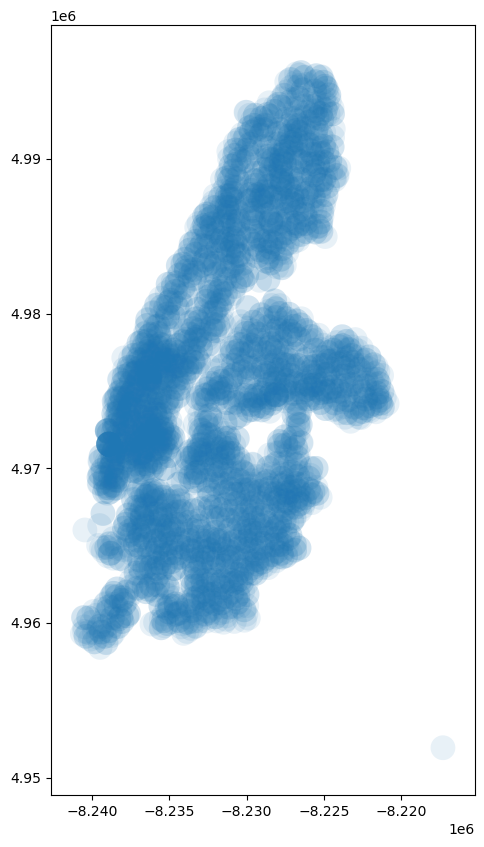

In [10]:
#plotting just edges was very confusing, so I instead plot the shapes with a semi-transparent fill

# bike_buffer.plot(figsize=(15,15),
#                   facecolor="none", 
#                   edgecolor="green", 
#                   lw=.5)

bike_buffer.plot(figsize=(10,10), alpha=0.1) 

Now read in the block group geometries, which are in the `nyc_cbg` zip file (1pt)

In [55]:
blocks = gpd.read_file("nyc_cbg")

#we also set the crs to be consistent with the bikes
blocks = blocks.to_crs(epsg=3857)

And read in the block group attribute tables (1pt)

In [12]:
attributes= pd.read_csv('acs_race_cbg.csv')

Create a column in your block group geometries geodataframe called `area`, which will have the area of each Block Group (1 pt)

In [62]:
blocks['area']=blocks.area

Replace the `NaN` values with 0 (1 pt)

In [14]:
# there are no NaN values in the blocks (all geometry area>0)
#print(blocks.isna().sum()) #uncomment to see

# the NaN in the attribute table is all in the Population_density column
#print(attributes.isna().sum()) #uncomment to see

#since I know population density is a number, I will just replace all NaN with 0
attributes = attributes.fillna(0)

#I check there's no NaN just in case
attributes.isna().sum() #all 0s, great!

Unnamed: 0            0
GISJOIN               0
COUNTY                0
Population            0
Population_density    0
Hispanic              0
White                 0
Black                 0
Native                0
Asian                 0
Pacific               0
dtype: int64

Merge the attribute data with the geometries. 

In [64]:
# we need the geometry for later analysis, so I will merge attributes into blocks (and not other way around)
block_groups= blocks.merge(attributes, left_on="GISJOIN", right_on="GISJOIN")

#the unnamed column doesn't seem to represent anything, so I will drop it
block_groups.drop(columns="Unnamed: 0", inplace=True)

How many rows do you have in your new merged dataframe and how many row did you have originally in the geometry dataframe? (1pt)

In [16]:
#TODO: is this expected, or should we be merging other way around?
row_prev, _ =blocks.shape
row_curr, _ = block_groups.shape
print(f"rows in merged: {row_curr}, original rows in geometry dataframe: {row_prev}")

#that is, there are the same number of rows

rows in merged: 6592, original rows in geometry dataframe: 6592


In [65]:
blocks

,GISJOIN,COUNTYFP,geometry,area
0,G36000500001001,005,"POLYGON ((-8225044.732 4982597.565, -8224711.8...",2.928983e+06
1,G36000500002001,005,"POLYGON ((-8221803.782 4984851.366, -8221858.6...",1.555542e+05
2,G36000500002002,005,"POLYGON ((-8221803.782 4984851.366, -8221740.9...",3.415756e+05
3,G36000500002003,005,"POLYGON ((-8221569.789 4984446.304, -8221551.7...",2.941392e+05
4,G36000500004001,005,"POLYGON ((-8221569.789 4984446.304, -8221627.1...",1.098734e+05
...,...,...,...,...
6587,G36008500319012,085,"POLYGON ((-8255498.420 4957743.537, -8255500.6...",3.967763e+05
6588,G36008500319021,085,"POLYGON ((-8256324.516 4959572.771, -8256356.3...",2.292494e+05
6589,G36008500319022,085,"POLYGON ((-8255956.382 4959602.845, -8255980.5...",3.915545e+05
6590,G36008500319023,085,"POLYGON ((-8255474.815 4959416.824, -8255470.4...",5.796268e+05


## Part 2 - Analysis
Now, Citi Bike says then can put 10 new stations across 10 different block groups not currently within walking distance to a station. 


Here are the factors important to them (in no order): 
- **Proportion of block group not covered** (for ex: if a bg is 90% not covered by 10% not covered, they will prioritize the 90%)
- **Population density**: They would rather put a station in a block group that has more people per block
- **Proximity to the city center**: They know that many people use Citibike to get to work, so they would prefer for these stations to be as close to downtown Manhanttan as possible
- **Equity**: They hope to put these stations where the proportion of non-White residents is high. 

First, create a new dataframe of Census block groups not covered by the Citi bike walking buffers. Make sure to check your CRSs. (5pts)

In [66]:
#I first need to convert block_groups to the correct CRS
block_groups = block_groups.to_crs(epsg=3857)

#then I join the bike buffer geometry using dissolve to find all the area coverd
all_area_covered_by_bikes = bike_buffer.dissolve()

# #then I use a spatial join to find bike buffers in each block, and count them
# station_counts = gpd.sjoin(block_groups,bike_buffer,how='left').groupby("GISJOIN")["station_id"].count()

# #I get the blocks that don't have any buffers intersecting them, convert to a list
# blocks_without_stations = station_counts[station_counts==0].reset_index()["GISJOIN"].tolist()

# #use the list to index the blocks from the original gdf
# block_groups_without_stations = block_groups[block_groups["GISJOIN"].isin(blocks_without_stations)]

In [68]:
diff = block_groups.overlay(all_area_covered_by_bikes, how="difference")

In [69]:
block_groups.area

0       2.928983e+06
1       1.555542e+05
2       3.415756e+05
3       2.941392e+05
4       1.098734e+05
            ...     
6587    3.967763e+05
6588    2.292494e+05
6589    3.915545e+05
6590    5.796268e+05
6591    6.784474e+06
Length: 6592, dtype: float64

In [70]:
diff["uncovered area"] =diff.area

In [71]:
diff

,GISJOIN,COUNTYFP,geometry,area,COUNTY,Population,Population_density,Hispanic,White,Black,Native,Asian,Pacific,uncovered area
0,G36000500001001,005,"POLYGON ((-8225044.732 4982597.565, -8224711.8...",2.928983e+06,Bronx County,3772,0.002249,1259,260,2172,6,59,0,2.928983e+06
1,G36000500002001,005,"POLYGON ((-8221803.782 4984851.366, -8221858.6...",1.555542e+05,Bronx County,1330,0.014942,950,31,272,3,22,0,1.555542e+05
2,G36000500002002,005,"POLYGON ((-8221803.782 4984851.366, -8221740.9...",3.415756e+05,Bronx County,2057,0.010523,1330,59,496,12,86,0,3.415756e+05
3,G36000500002003,005,"POLYGON ((-8221569.789 4984446.304, -8221551.7...",2.941392e+05,Bronx County,1392,0.008269,893,62,243,5,94,0,2.941392e+05
4,G36000500004001,005,"POLYGON ((-8221569.789 4984446.304, -8221627.1...",1.098734e+05,Bronx County,1047,0.016652,761,28,142,2,52,2,1.098734e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,G36008500319012,085,"POLYGON ((-8255498.420 4957743.537, -8255500.6...",3.967763e+05,Richmond County,1119,0.004901,431,90,383,1,146,2,3.967763e+05
3197,G36008500319021,085,"POLYGON ((-8256324.516 4959572.771, -8256356.3...",2.292494e+05,Richmond County,1886,0.014302,453,184,1164,8,13,0,2.292494e+05
3198,G36008500319022,085,"POLYGON ((-8255956.382 4959602.845, -8255980.5...",3.915545e+05,Richmond County,1782,0.007912,628,153,880,4,38,0,3.915545e+05
3199,G36008500319023,085,"POLYGON ((-8255474.815 4959416.824, -8255470.4...",5.796268e+05,Richmond County,1832,0.005494,641,135,860,18,60,0,5.796268e+05


<Axes: >

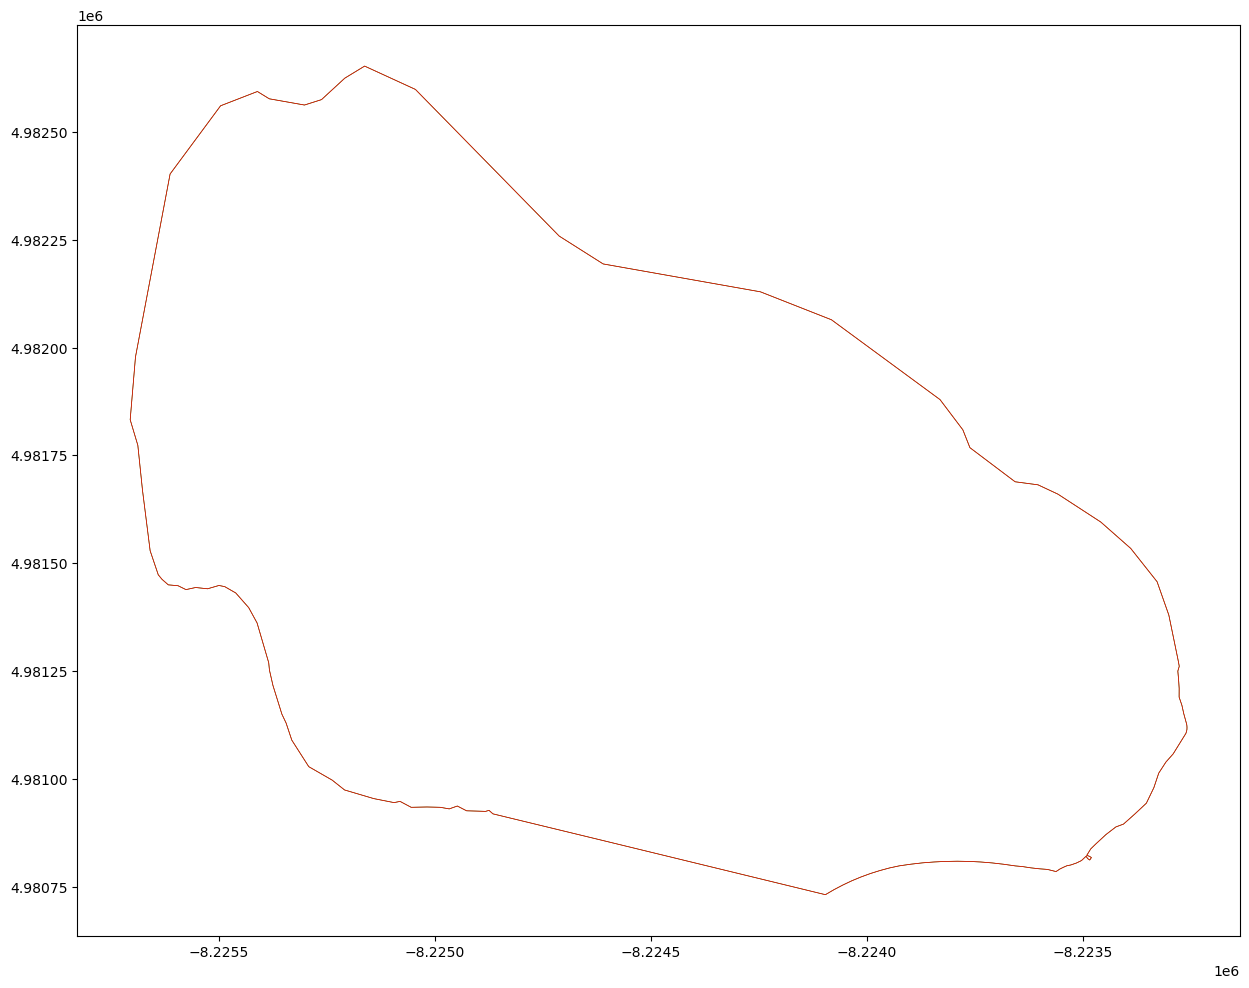

In [46]:
fig2, ax2 = plt.subplots(figsize=(15, 15))

diff[diff["GISJOIN"]=="G36000500001001"].plot(ax=ax2, facecolor="none", 
                            edgecolor="green", 
                            lw=.5)
block_groups[block_groups["GISJOIN"]=="G36000500001001"].plot(ax=ax2, facecolor="none", 
                            edgecolor="red", 
                            lw=.5)

<Axes: >

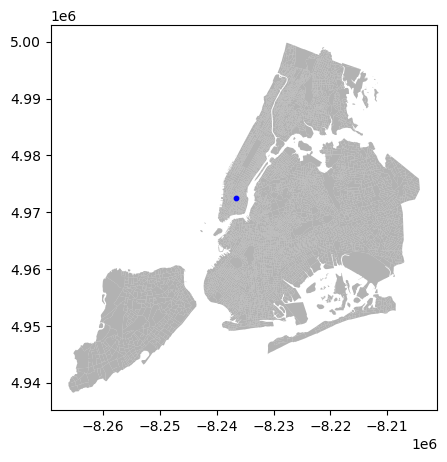

In [20]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(5, 5))

# block_groups_without_stations.plot(ax=ax1,
#                             alpha=.6,
#                             color = 'grey')


# markersize is the marker size
# bike_buffer.plot(color='red',
#             ax=ax1,
#             alpha=0.05)

block_groups.plot(ax=ax1,
                            alpha=.6,
                            color = 'grey')

gpd.GeoDataFrame(geometry=gpd.points_from_xy([-8236653.33779], [4972575.11631]), crs="epsg:3857").plot(ax=ax1, color="blue",  markersize=10)

How many block groups are not covered? (1 pt)

In [21]:
# INSERT YOUR CODE HERE

len, _ = block_groups_without_stations.shape
block_groups.shape
print(len)

2995


Now, let's create the proportion of the block group that hasn't been covered (3 pts)

In [22]:
# INSERT YOUR CODE HERE
#TODO: what am I supposed to do here? not covered/ covered?

Next, let's calculate distance from each centroid of the not covered block groups to Manhattan city center. 

First, what's our current CRS? Let's convert our uncovered block group geodataframe CRS to 3857. (1 pt)

In [23]:
# current crs is already 3857, so I don't do conversion:
# if I did, the code would be: block_groups_without_stations.to_crs(epsg=3857)
block_groups_without_stations.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next we want to find the distance between each block group and downtown Manhttan. 

Using chatgpt, find the lat/lng for Downtown Manhattan in EPSG: 3857. Was it correct? (2 pts) By correct, I don't mean whether the location in the city was correct (you can use anywhere below Central Park as "downtown"), but whether the format and CRS were correct. 

the answer it gave me was in EPSG:4326, and not in EPSG:3857
<li>Latitude: 40.7219, Longitude: -74.0032</li>

after some prompting, it gave me the correct crs, but the location was in brooklyn 
<li>X: -8236575.988, Y: 4968480.521</li>

then finally, after more prompting, it gave a correct answer:
<li>X: -8238480.943, Y: 4971068.849</li>


Create a geodataframe with one point in Downtown Manhattan with a 3857 CRS (5 pts)

In [24]:
# I'm using Astor Place as my downtown location, which approximately has (x,y) = (-8236653.33779, 4972575.11631)
downtown_pt = gpd.GeoDataFrame(geometry=gpd.points_from_xy([-8236653.33779], [4972575.11631]), crs="epsg:3857")

Find the distance between this point and all uncovered block groups (3 pts)

In [25]:
#first we check they have the same crs (epsg: 3857)
downtown_pt.crs == block_groups_without_stations.crs

True

In [26]:
block_groups_without_stations["geometry"].centroid.distance(downtown_pt["geometry"][0])

0       15058.980585
1       19055.579258
2       18882.634692
3       18882.287499
4       19356.882331
            ...     
6587    24227.384304
6588    23883.678560
6589    23733.168228
6590    23479.032588
6591    25162.064630
Length: 2995, dtype: float64

We already know the population density.

Lastly, find the percent non-white residents in each block group (3 pts)

In [27]:
# INSERT YOUR CODE HERE

Lastly, create you own method of finding your top 10 block groups based on these criteria. You must you all four criteria from above. Please explain how you decided on your method and which criteria to prioritize. (10 pts) 

Here are some ideas: 
- You can create a threshold for each column and find the 10 block groups that fulfill all criteria (for ex: `perc_non_white` has to be greater than 50%, etc etc)
- You can create a score that combines all four criteria in some way. 



In [28]:
# INSERT YOUR CODE HERE